In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
df = pd.read_csv('datasets/comparison_timeseries.csv', skiprows=[0], parse_dates=[0], index_col=0, dayfirst=True)

In [3]:
df.head()

,Kubernetes: (Worldwide),Apache Hadoop: (Worldwide),Apache Spark: (Worldwide),Apache Druid: (Worldwide),Ansible: (Worldwide)
Week,,,,,
2015-09-27,4,60,26,<1,15
2015-10-04,4,61,29,<1,17
2015-10-11,4,62,27,<1,22
2015-10-18,5,58,26,<1,22
2015-10-25,5,61,30,<1,20


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Kubernetes: (Worldwide),261.0,49.555556,32.469894,3.0,17.0,51.0,83.0,100.0
Apache Hadoop: (Worldwide),261.0,44.310345,10.378206,25.0,36.0,45.0,53.0,63.0
Apache Spark: (Worldwide),261.0,44.969349,7.478625,19.0,40.0,47.0,51.0,56.0
Ansible: (Worldwide),261.0,44.666667,11.753886,12.0,34.0,49.0,53.0,61.0


In [5]:
df.dtypes

Kubernetes: (Worldwide)        int64
Apache Hadoop: (Worldwide)     int64
Apache Spark: (Worldwide)      int64
Apache Druid: (Worldwide)     object
Ansible: (Worldwide)           int64
dtype: object

In [6]:
new=[]
for i in df.columns:
    new.append(i.replace(': (Worldwide)', ''))
df.columns = new
df.columns

Index(['Kubernetes', 'Apache Hadoop', 'Apache Spark', 'Apache Druid',
       'Ansible'],
      dtype='object')

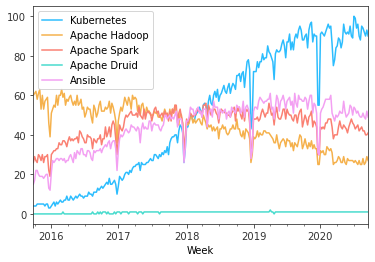

In [311]:
df['Apache Druid'][df['Apache Druid'] == '<1'] = 0
df['Apache Druid'] = df['Apache Druid'].astype('int64')
df.plot()

# Model

In [8]:
# univariate cnn lstm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [9]:
def split_sequence(sequence, n_steps):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [10]:
# define model
def create_model(n_steps, n_features):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64,
                                kernel_size=1, 
                                activation='relu'), 
                                input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [11]:
def predict_n(data, n, model):
    predictions = data[-n_steps*2:].tolist()
    output = []
    x_input = None
    for i in range(n):
        if i != 0:
            predictions.pop(0)
            x_input = np.array(predictions)
        else:
            x_input = data[-n_steps*2:]
        x_input = x_input.reshape((1, n_seq, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        predictions.append(yhat[0,0])
        output.append(yhat[0,0])
    return output

In [246]:
n_steps = 110
n_features = 1
n_seq = 2
raw_seq_k = df.Kubernetes.values
for i in range(5):
    X, y = split_sequence(raw_seq_k, n_steps*2)
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

    model = create_model(n_steps, n_features)
    model.fit(X, y, epochs=300, verbose=0)

    output = predict_n(raw_seq_k, 25, model)
    raw_seq_k = np.append(raw_seq_k, output)

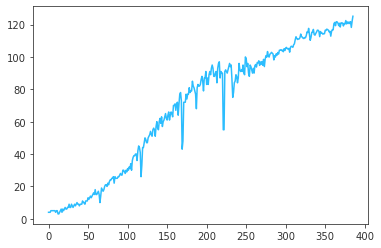

In [310]:
plt.plot(np.arange(len(raw_seq_k)), raw_seq_k)

In [65]:
n_steps = 84#100
n_features = 1
n_seq = 2
raw_seq_h = df['Apache Hadoop'].values
for i in range(5):
    X, y = split_sequence(raw_seq_h, n_steps*2)
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

    model = create_model(n_steps, n_features)
    model.fit(X, y, epochs=300, verbose=0)

    output = predict_n(raw_seq_h, 25, model)
    raw_seq_h = np.append(raw_seq_h, output)

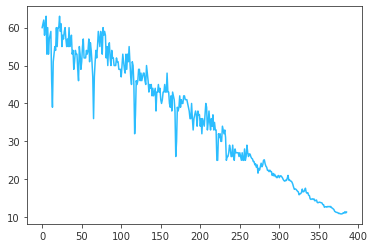

In [305]:
plt.plot(np.arange(len(raw_seq_h)), raw_seq_h)

In [34]:
n_steps = 84 # 32
n_features = 1
n_seq = 2
raw_seq_s = df['Apache Spark'].values
for i in range(5):
    X, y = split_sequence(raw_seq_s, n_steps*2)
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

    model = create_model(n_steps, n_features)
    model.fit(X, y, epochs=300, verbose=0)

    output = predict_n(raw_seq_s, 25, model)
    raw_seq_s = np.append(raw_seq_s, output)

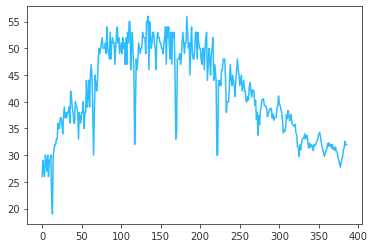

In [306]:
plt.plot(np.arange(len(raw_seq_s)), raw_seq_s)

In [38]:
n_steps = 128 # 32
n_features = 1
n_seq = 2
raw_seq_d = df['Apache Druid'].values
for i in range(5):
    X, y = split_sequence(raw_seq_d, n_steps*2)
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

    model = create_model(n_steps, n_features)
    model.fit(X, y, epochs=300, verbose=0)

    output = predict_n(raw_seq_d, 25, model)
    raw_seq_d = np.append(raw_seq_d, output)

In [49]:
raw_seq_d = raw_seq_d.astype('int64')

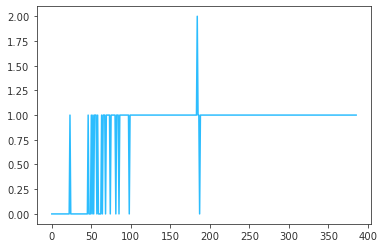

In [307]:
plt.plot(np.arange(len(raw_seq_d)), raw_seq_d)

In [51]:
n_steps = 84 # 32
n_features = 1
n_seq = 2
raw_seq_a = df['Ansible'].values
for i in range(5):
    X, y = split_sequence(raw_seq_a, n_steps*2)
    X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

    model = create_model(n_steps, n_features)
    model.fit(X, y, epochs=300, verbose=0)

    output = predict_n(raw_seq_a, 25, model)
    raw_seq_a = np.append(raw_seq_a, output)

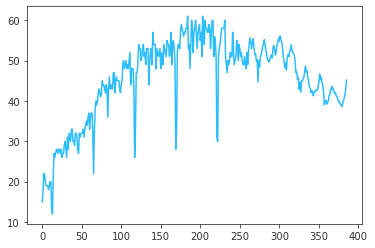

In [308]:
plt.plot(np.arange(len(raw_seq_a)), raw_seq_a)

In [53]:
df.columns

Index(['Kubernetes', 'Apache Hadoop', 'Apache Spark', 'Apache Druid',
       'Ansible'],
      dtype='object')

In [285]:
index = date_rng = pd.date_range(start='2015-09-27', periods=386, freq='W')

df_predict = pd.DataFrame({'Kubernetes':raw_seq_k, 
                            'Apache Hadoop':raw_seq_h, 
                            'Apache Spark':raw_seq_s, 
                            'Apache Druid':raw_seq_d, 
                            'Ansible':raw_seq_a},
                            index=index)

In [286]:
df_predict = df_predict.astype('int64')
df_predict = df_predict.mul(100/df_predict.Kubernetes.max())

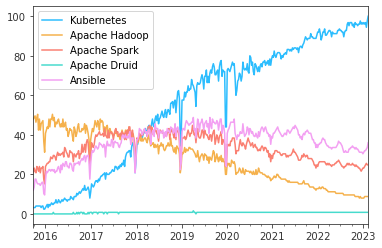

In [309]:
df_predict.plot()

In [290]:
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Red = '#FA8072'
CB91_Amber = '#F5B14C'
DARK_GRAY = '#333333'
color_list = [CB91_Blue, CB91_Amber, CB91_Red, CB91_Green, CB91_Pink]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

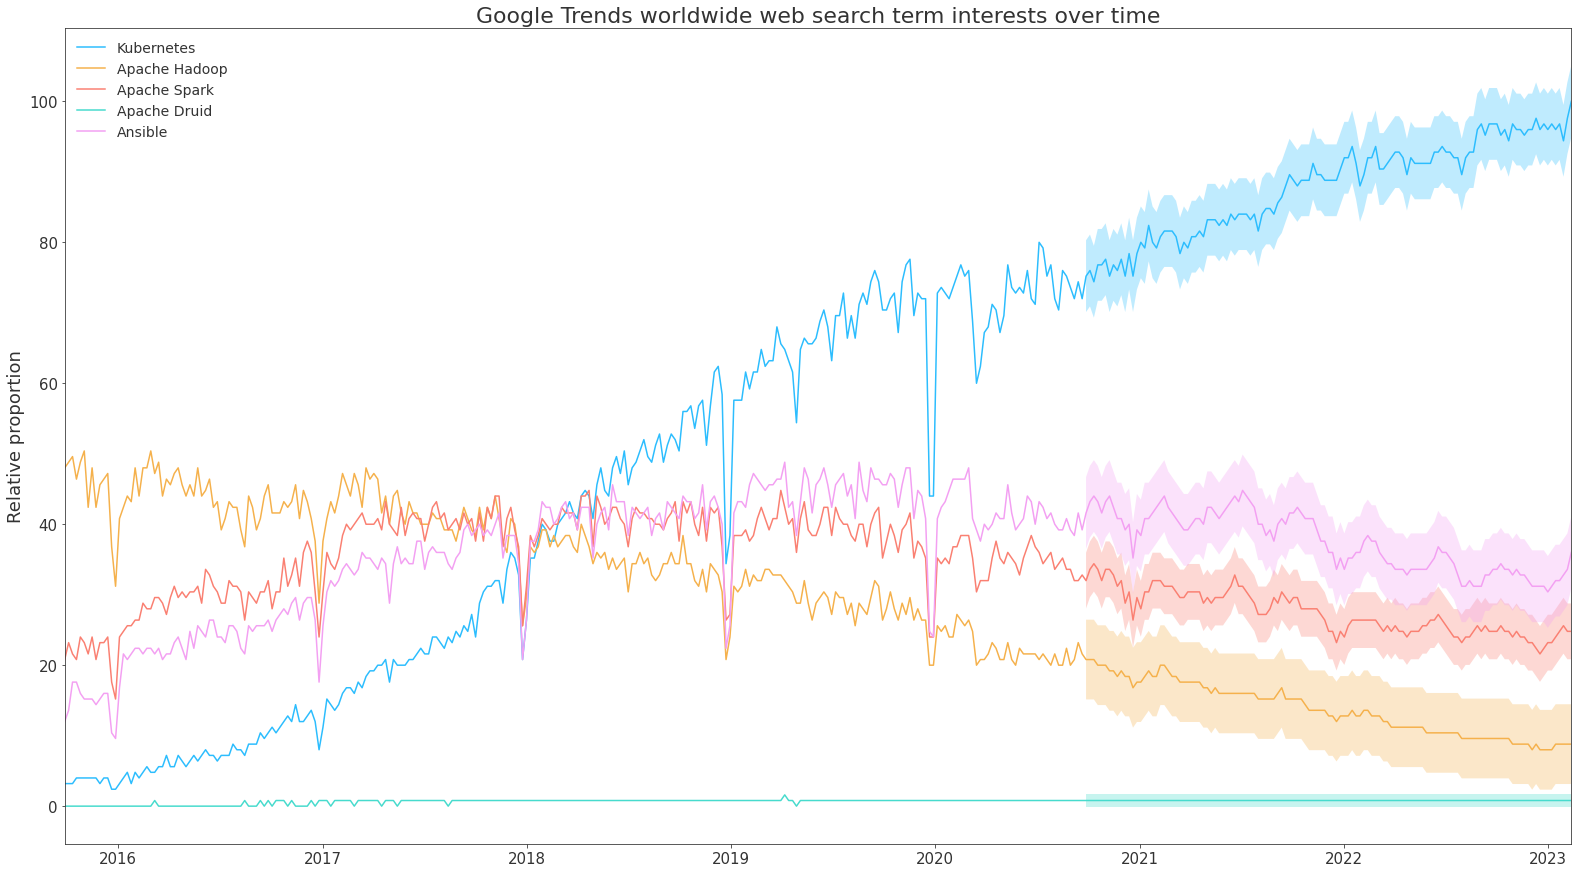

In [304]:
np.random.seed(42)
plt.rc_context({'axes.edgecolor':DARK_GRAY, 'xtick.color':DARK_GRAY, 'ytick.color':DARK_GRAY})
fig, ax = plt.subplots(figsize=(27, 15))
for i in df.columns:
    if i != 'Apache Druid':
        ci = np.random.randint(7,11)*np.std(df_predict.Kubernetes)/np.mean(df_predict.Kubernetes)
    else:
        ci = 2*np.std(df_predict[i])/np.mean(df_predict[i])
    x = df_predict.index
    y = df_predict[i]
    ax.plot(x, y, label=i, linewidth=1.5)

    x = df_predict.index[len(df):]
    y = df_predict[i][len(df):]
    ax.fill_between(x, y-ci, y+ci, alpha=0.3)
    ax.set_xlim([df_predict.index[0],df_predict.index[-1]])
    ax.tick_params(axis='both', which='major', labelsize=15)

plt.title('Google Trends worldwide web search term interests over time', color=DARK_GRAY, fontsize=22)
plt.ylabel('Relative proportion', color=DARK_GRAY, fontsize=18)
l = plt.legend(frameon=False, fontsize=14)
for text in l.get_texts():
    text.set_color(DARK_GRAY)

# plt.savefig('comparison_dla_damiana.png')